## CSCI S-89C Deep Reinforcement Learning, Summer 2020
### Section 9

## TD($\lambda$) with Approximation for Estimating $v_\pi$

We again consider patients with end-stage liver disease (ESLD). We assume that patient's health condition is fully characterized by the Model for End-stage Liver Disease (MELD) score (Jae-Hyeon Ahn and John Hornberger, Involving patients in the cadaveric kidney transplant allocation process: a decision-theoretic perspective. Manage Sci. 1996;42(5):629–41).

The MELD score ranges from 6 to 40 and is derived based on the probability of survival at 3 months for patients with ESLD. Data in ESLD is usually sparse and often aggregated into Stages. We assume that there are 18 stages based on the ESLD: Stage 1, Stage2, ..., Stage 18. The time step is 1 year and the actions in Stages 1 through 18 are "wait" (denoted by 0) and "transplant" (denoted by 1). 

We assume that the Markov property holds. There are two additional states of the Markov Decision Process: "Posttransplant Life" (denoted by 19) and "Death" (which is denoted by 20 and combines so caled "Pretransplant Death" and "Posttransplant Death"). The only action availible in state "Posttransplant Life" is "wait" and "Death" is the terminal state with no actions. Assume that the length of an episode is T=50, unless it terminates earlier due to the transition to the absorbing state "Death."

We do not know the transition probabilities, but if a patient selects "wait," the possible transitions are   
1) Stage 1->Stage 1, Stage 1->Stage 2, Stage 1->Death  
2) For k in {2,3,4,...17}, Stage k->Stage (k-1), Stage k->Stage k, Stage k->Stage (k+1), Stage k->Death    
3) Stage 18->Stage 17, Stage 18->Stage 18, Stage 18->Death    

If a patient selects "transplant" at Stage k, k=1,2,...,18, the only possible transition is  
4) Stage k->"Posttransplant Life"

Finally, there are two more possible transitions"  
5) "Posttransplant Life"->"Posttransplant Life" and "Posttransplant Life"->"Death"  


The patient gets reward 1 in all states "Stage k" (k=1,2,...,18) and reward 0.2 in the "Posttransplant Life" state - assume that the patient gets these rewards on "exit" from the states, i.e. after we observe the corresponding stage. We assume the discounting parameter $\gamma=0.97$, one of the most common discounting rate used in medical decision making (Gold MR, Siegel JE, Russell LB, Weinstein MC. Cost-Effectiveness in Health and Medicine. Oxford University Press; New York: 1996).


Please consider statistics on 8,000 patients with ESLD saved in the 'ESLD_statistics.csv' file. Eeach row represents an episode (i.e. one patient) and the columns are the sequences of the patients' states and actions. This data were generated under the following policy:

$\pi(1|k)=0.02$ for $k\in\{1,2,3,4,5,6,7,8,9,10,11,12,13\}$;   
$\pi(1|14)=0.05$;   
$\pi(1|15)=0.10$;   
$\pi(1|16)=0.20$;   
$\pi(1|17)=0.40$;  
$\pi(1|18)=0.60$;  

which means that, for example, 5% of paients at stage 14 received a transplant.   
     
     
Let's approximate the state-values as follows:

$$v_\pi(s)\approx\hat{v}(s,{\bf w}) = \sum_{k=1}^{18} \left(w_1+w_2\, \frac{k-9}{5}+w_3\, \left(\frac{k-9}{5}\right)^2\right)\cdot \mathbb{1}_{(s=\text{"Stage }k\text{"})}+w_4\cdot \mathbb{1}_{(s=\text{"Posttransplant Life"})},$$

where ${\bf w}=(w_1,w_2,w_3,w_4)^T$. Please notice that $\hat{v}(\text{"Death"},{\bf w})=0$. 


### 1. Tabular TD($\lambda$), $\lambda=0.8$ (with experience replay)

Let's run tabular TD($\lambda$) first:

In [73]:
import random
from matplotlib import pyplot as plt 
import numpy as np
import pandas as pd

In [74]:
df = pd.read_csv('data/ESLD_statistics.csv')
df.head(5)

,S0,A0,S1,A1,S2,A2,S3,A3,S4,A4,...,A45,S46,A46,S47,A47,S48,A48,S49,A49,S50
0,12,0,12,0,13,0,13,0,20,0,...,0,20,0,20,0,20,0,20,0,20
1,3,0,3,0,3,0,3,0,3,0,...,0,20,0,20,0,20,0,20,0,20
2,16,0,16,0,16,1,19,0,19,0,...,0,20,0,20,0,20,0,20,0,20
3,13,0,13,0,13,0,13,0,14,0,...,0,20,0,20,0,20,0,20,0,20
4,4,0,4,0,4,0,20,0,20,0,...,0,20,0,20,0,20,0,20,0,20


In [75]:
k = 2
states = df.values[k,0:-1:2]
states

array([16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
      dtype=int64)

In [76]:
rewards = (states <= 18)*1 + (states == 19)*0.2
rewards

array([1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
       0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [77]:
k = 2
actions = df.values[k,1::2]
actions

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [78]:
def get_episode(df, k):
    states = df.values[k,0:-1:2]
    actions = df.values[k,1::2]
    rewards = (states <= 18)*1 + (states == 19)*0.2
    return [states, actions, rewards]

In [79]:
get_episode(df, 2)

[array([16, 16, 16, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
        19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
        20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20],
       dtype=int64),
 array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int64),
 array([1. , 1. , 1. , 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])]

In [80]:
np.random.seed(3455)

alpha = 1
gamma = 0.97
lam = 0.8
T = 50
num_episodes = df.shape[0]
V_lam = np.zeros(20)
num_epochs = 1000000
V_lam_history = V_lam.reshape((20,1))
N = 0
Z = np.zeros(20)

for i in range(num_epochs):
    if (int(N/50)*50==N):
        Z = np.zeros(20) 
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    gradV = np.zeros(20)
    gradV[S-1] = 1
    #gradV[19] = 0
    Z = gamma*lam*Z + gradV 
    V_lam = V_lam + alpha/np.sqrt(N)*(R + gamma*V_lam[S1-1] - V_lam[S-1])*Z
    if (int(N/100)*100==N):
        V_lam_history = np.append(V_lam_history, V_lam.reshape((20,1)), axis=1)

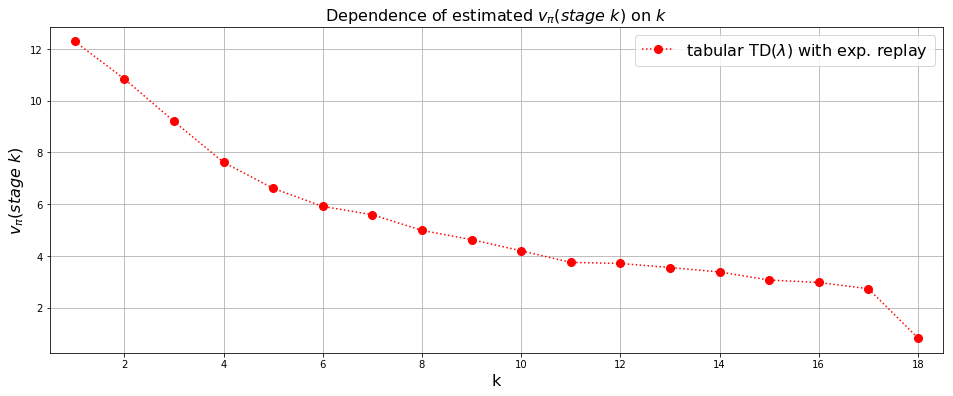

In [98]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V_lam[0:18], linestyle=':', marker="o",color = "r", markersize=8, label='tabular TD($\lambda$) with exp. replay')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

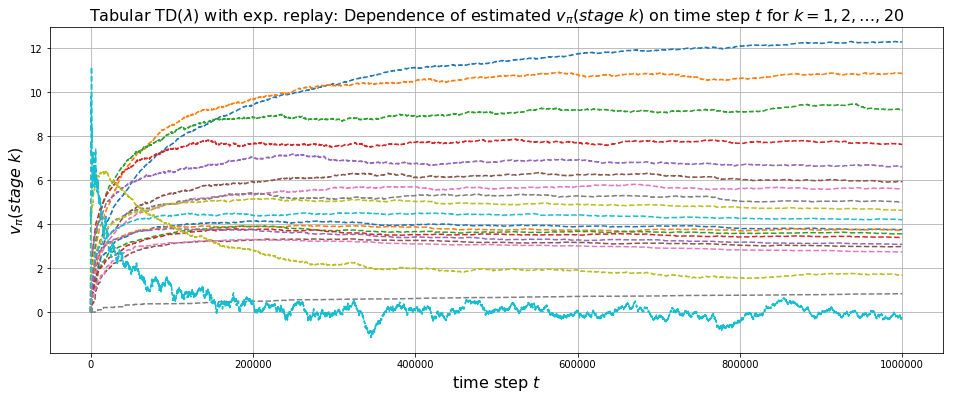

In [82]:
plt.figure(figsize=(16,6))
plt.plot(range(1,V_lam_history.shape[1]*100,100),np.transpose(V_lam_history), linestyle='--', marker=None, markersize=4)
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Tabular TD($\lambda$) with exp. replay: Dependence of estimated $v_\pi(stage\,\,k)$ on time step $t$ for $k=1,2,\ldots,20$',fontsize=16)
plt.grid(True)

### 2. TD($\lambda$), $\lambda=0.8$, with approximation (and experience replay)

In [83]:
def v_hat(k, w):
    v = (w[0] + w[1]*(k-9)/5 + w[2]*((k-9)/5)**2)*(k<=18) + w[3]*(k==19)
    return v

In [84]:
def dv_hat(k, w):
    dv = [1, (k-9)/5, ((k-9)/5)**2, 0]*int(k<=18) + [0, 0, 0, 1]*int(k==19) + [0, 0, 0, 0]*int(k==20)
    return np.array(dv)

In [85]:
np.random.seed(3455)

alpha = 0.2
gamma = 0.97
lam = 0.8
T = 50
num_episodes = df.shape[0]
num_epochs = 500000
w_replay = np.zeros(4)
w_replay_history = w_replay.reshape((4,1))
N = 0
Z = np.zeros(4)

for i in range(num_epochs):
    if (int(N/50)*50==N):
        Z = np.zeros(4) 
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    Z = gamma*lam*Z + dv_hat(S,w_replay)
    w_replay = w_replay + alpha/(N**0.4)*(R + gamma*v_hat(S1,w_replay) - v_hat(S,w_replay))*Z
    if (int(N/1000)*1000==N):
        w_replay_history = np.append(w_replay_history, w_replay.reshape((4,1)), axis=1)

In [86]:
w_replay

array([ 4.25912901, -2.82632093,  1.34519142,  1.80409685])

In [87]:
V_replay_hat = [v_hat(k,w_replay) for k in range(1,21)]
V_replay_hat

[12.224932523765423,
 10.852553486662758,
 9.587789763083688,
 8.43064135302821,
 7.381108256496331,
 6.439190473488046,
 5.604888004003356,
 4.878200848042259,
 4.259129005604758,
 3.7476724766908522,
 3.343831261300541,
 3.047605359433825,
 2.8589947710907038,
 2.777999496271177,
 2.8046195349752456,
 2.9388548872029086,
 3.180705552954168,
 3.53017153222902,
 1.804096852668743,
 0.0]

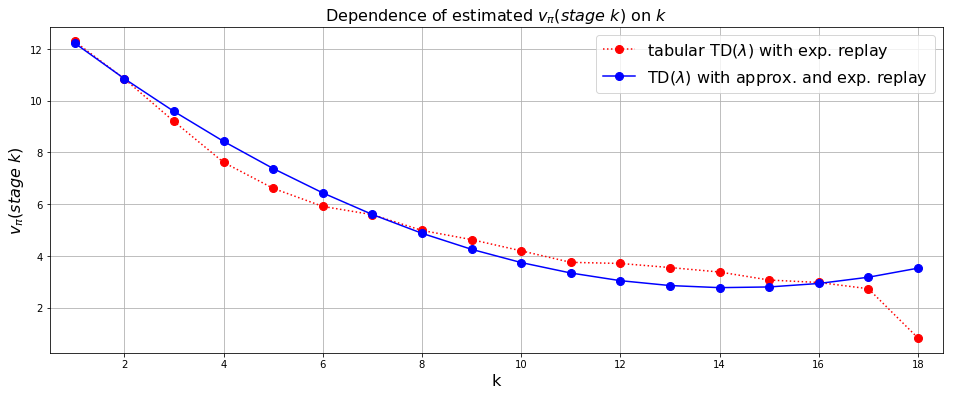

In [100]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V_lam[0:18], linestyle=':', marker="o",color = "r", markersize=8, label='tabular TD($\lambda$) with exp. replay')
plt.plot(range(1,19),V_replay_hat[0:18], linestyle='-', marker="o",color = "b", markersize=8, label='TD($\lambda$) with approx. and exp. replay')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()

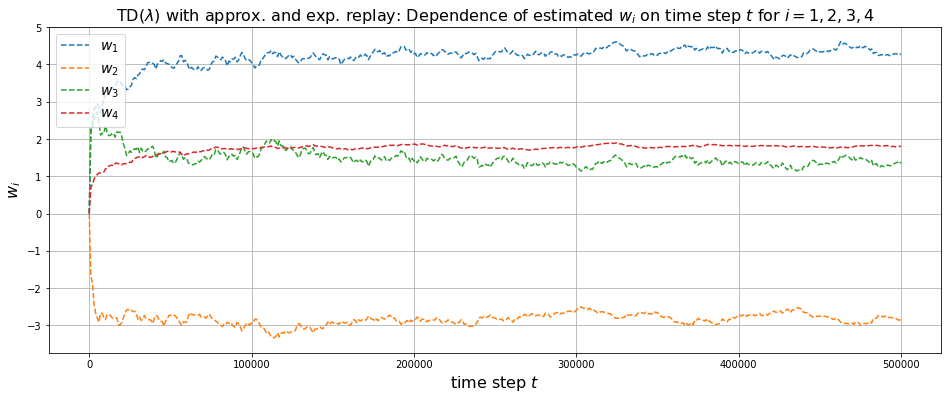

In [92]:
plt.figure(figsize=(16,6))
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[0], linestyle='--', marker=None, markersize=4,label='$w_1$')
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[1], linestyle='--', marker=None, markersize=4,label='$w_2$')
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[2], linestyle='--', marker=None, markersize=4,label='$w_3$')
plt.plot(range(1,w_replay_history.shape[1]*1000,1000),w_replay_history[3], linestyle='--', marker=None, markersize=4,label='$w_4$')
plt.xlabel("time step $t$",fontsize=16)
plt.ylabel("$w_i$",fontsize=16)
plt.title('TD($\lambda$) with approx. and exp. replay: Dependence of estimated $w_i$ on time step $t$ for $i=1,2,3,4$',fontsize=16)
plt.grid(True)
plt.legend(loc = 'upper left',fontsize=14)
plt.show()

### 3. Tabular 1-step TD and comparison

In [90]:
np.random.seed(3455)

alpha = 1
gamma = 0.97
T = 50
num_episodes = df.shape[0]
V_replay = np.zeros(20)
num_epochs = 1000000
V_replay_history = V_replay.reshape((20,1))
N = 0

for i in range(num_epochs):
    N = N + 1
    k = np.random.randint(low=1, high=num_episodes, size=1)[0]
    episode = get_episode(df, k)
    t = np.random.randint(low=0, high=49, size=1)[0]
    S = episode[0][t]
    S1 = episode[0][t+1]
    R = episode[2][t]
    V_replay[S-1] = V_replay[S-1] + alpha/np.sqrt(N)*(R + gamma*V_replay[S1-1] - V_replay[S-1])
    if (int(N/100)*100==N):
        V_replay_history = np.append(V_replay_history, V_replay.reshape((20,1)), axis=1)

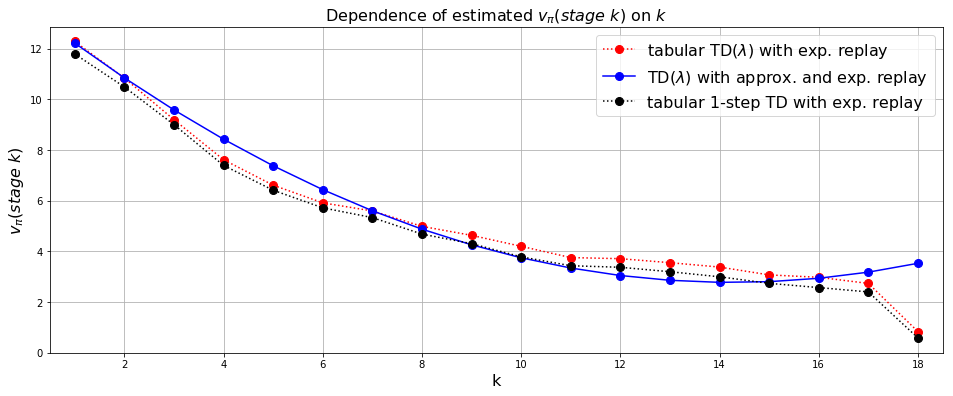

In [97]:
plt.figure(figsize=(16,6))
plt.plot(range(1,19),V_lam[0:18], linestyle=':', marker="o",color = "r", markersize=8, label='tabular TD($\lambda$) with exp. replay')
plt.plot(range(1,19),V_replay_hat[0:18], linestyle='-', marker="o",color = "b", markersize=8, label='TD($\lambda$) with approx. and exp. replay')
plt.plot(range(1,19),V_replay[0:18], linestyle=':', marker="o",color = "k", markersize=8, label='tabular 1-step TD with exp. replay')
plt.xlabel("k",fontsize=16)
plt.ylabel("$v_\pi(stage\,\,k)$",fontsize=16)
plt.title('Dependence of estimated $v_\pi(stage\,\,k)$ on $k$',fontsize=16)
#plt.ylim(0, 13)
plt.xlim(0.5,18.5)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize=16)
plt.show()